<h3> Análisis de variabilidad climática en Nevados Colombianos mediante datos de TerraClimate y Google Earth Engine 1960 - 2022 </h3>
<p><strong>Nombre: </strong> Juan Sebastián Hernández Santana </p>
<p><strong>Fecha: </strong> 21 de Diciembre de 2023 </p>

In [1]:
# Conexión con Google Earth Engine
import geemap
import ee
# Manejo de datos
import pandas as pd
import numpy as np
# Manejo de gráficos
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# Funciones

# Recortar las imágenes de la colección
def clip_image(img):
    return img.clip(nevado).copyProperties(img, ["system:time_start"])
# Aplicar el factor de escala para TerraClimate (0.1)
def scale_image(img):
    return img.multiply(0.1).copyProperties(img,["system:time_start"])
# Obtener métricas de temperatura máxima y mínima de la zona de estudio
def obtener_temp_extrema(coleccion, banda, tipo):
    temp_extrema = coleccion \
        .filterDate("1960-01-01", "2022-12-31") \
        .filterBounds(nevado) \
        .select(banda) \
        .map(lambda image: image.clip(nevado)) \
        .map(lambda image: image.multiply(0.1))
    
    if tipo == 'max':
        return temp_extrema.max().reduceRegion(**{
            "reducer": ee.Reducer.max(),
            "geometry": nevado,
            "scale": 4638.312116386398,
            "maxPixels": 1e9
        })
    elif tipo == 'min':
        return temp_extrema.min().reduceRegion(**{
            "reducer": ee.Reducer.min(),
            "geometry": nevado,
            "scale": 4638.312116386398,
            "maxPixels": 1e9
        })
# Extraer temperatura promedio por medio de temperaturas máximas y mínimas
def extract_temp_mean(img):
    maximos = img.select("tmmx").clip(nevado).multiply(0.1)
    minimos = img.select("tmmn").clip(nevado).multiply(0.1)
    promedio = (maximos.add(minimos)).divide(2)
    return promedio.rename("prom").copyProperties(img,["system:time_start"])
# Extraer el promedio de cada imagen de las temperaturas promedio
def temp_mean_reductor(img, tipo): 
    temp_mean_mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = nevado, scale = 4638.312116386398).get(tipo)
    return img.set('Fecha', img.date().format()).set('Promedio', temp_mean_mean)


In [2]:
ee.Initialize()

TerraClimate: Monthly Climate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idahovv

In [5]:
image_collection = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")

Geometría de los nevados

In [9]:
nevado = geemap.shp_to_ee('./Shapefile_Nevados/Nevado_Cocuy.shp')

Extracción de colección de imágenes desde 1960 a 2022 con la geometría del Nevado y aplicando recorte y factor de escala

In [23]:
temp_max = image_collection.filterDate("1960-01-01","2022-12-31").filterBounds(nevado).select("tmmx").map(clip_image).map(scale_image)
temp_min = image_collection.filterDate("1960-01-01","2022-12-31").filterBounds(nevado).select("tmmn").map(clip_image).map(scale_image)

Encontrar las métricas de la temperatura para el Nevado

In [26]:
max_temp_max = obtener_temp_extrema(image_collection, "tmmx", 'max')
min_temp_max = obtener_temp_extrema(image_collection, "tmmn", 'max')
max_temp_min = obtener_temp_extrema(image_collection, "tmmx", 'min')
min_temp_min = obtener_temp_extrema(image_collection, "tmmn", 'min')

data = {
    'Temp_Max_TodaSerie_MaxPx': [max_temp_max.getInfo()],
    'Temp_Min_TodaSerie_MaxPx': [min_temp_max.getInfo()],
    'Temp_Max_TodaSerie_MinPx': [max_temp_min.getInfo()],
    'Temp_Min_TodaSerie_MinPx': [min_temp_min.getInfo()]
}

df_resumen = pd.DataFrame(data)
df_resumen

,Temp_Max_TodaSerie_MaxPx,Temp_Min_TodaSerie_MaxPx,Temp_Max_TodaSerie_MinPx,Temp_Min_TodaSerie_MinPx
0,{'tmmx': 32.7},{'tmmn': 21.5},{'tmmx': 2.2},{'tmmn': -5.6000000000000005}


Ilustración de temperatura máxima y mínima

In [31]:
palette_max = ['green', 'red']
palette_min = ['blue', 'red']

Map.addLayer(temp_max.max(), {"palette": palette_max, "min": 9.4, "max": 33.3}, "Temperatura máxima")
Map.addLayer(temp_min.min(), {"palette": palette_min, "min": -5.6, "max": 16.9}, "Temperatura mínima")

Map.centerObject(nevado, 10)
Map

Map(bottom=126644.0, center=[6.517221442718537, -72.1793819255817], controls=(WidgetControl(options=['position…

In [36]:
temp_mean = image_collection.filterDate("1960-01-01","2022-12-31").filterBounds(nevado).map(extract_temp_mean)

In [39]:
print("Temperatura maxima de los promedios de todo el periodo y todos lo px")
temp_mean.max().reduceRegion(**{
  "reducer": ee.Reducer.max(),
  "geometry": nevado,
  "scale": 4638.312116386398,  #Tamaño del px
  "maxPixels": 1e9
})

print("Temperatura mínima de los promedios de todo el periodo y todos lo px")
temp_mean.min().reduceRegion(**{
  "reducer": ee.Reducer.min(),
  "geometry": nevado,
  "scale": 4638.312116386398,  #Tamaño del px
  "maxPixels": 1e9
})

Temperatura maxima de los promedios de todo el periodo y todos lo px
Temperatura mínima de los promedios de todo el periodo y todos lo px


In [42]:
Map.addLayer(temp_mean.mean(), {"palette": palette_max, "min":1.4, "max":23.8}, "Temperaturas promedio multianuales")
Map

Map(bottom=252978.0, center=[6.485889844658782, -72.11563110351564], controls=(WidgetControl(options=['positio…

In [51]:
Tprom_reducido_imgs = temp_mean.map(lambda img: temp_mean_reductor(img, 'prom'))
anidar_listaTprom = Tprom_reducido_imgs.reduceColumns(ee.Reducer.toList(2), ['Fecha','Promedio']).values().get(0)
df_Tprom = pd.DataFrame(anidar_listaTprom.getInfo(), columns=['Fecha','Promedio'])
df_Tprom['Fecha'] = pd.to_datetime(df_Tprom['Fecha'])
df_Tprom = df_Tprom.set_index('Fecha')

df_Tprom

,Promedio
Fecha,
1960-01-01,10.832558
1960-02-01,11.276696
1960-03-01,11.295412
1960-04-01,11.217637
1960-05-01,11.001341
...,...
2022-08-01,10.628191
2022-09-01,10.719059
2022-10-01,11.114378


In [52]:
Tmax_reducido_imgs = temp_max.map(lambda img: temp_mean_reductor(img, 'tmmx'))
anidar_listaTmax = Tmax_reducido_imgs.reduceColumns(ee.Reducer.toList(2), ['Fecha','Promedio']).values().get(0)
df_Tmax = pd.DataFrame(anidar_listaTmax.getInfo(), columns=['Fecha','Promedio'])
df_Tmax['Fecha'] = pd.to_datetime(df_Tmax['Fecha'])
df_Tmax = df_Tmax.set_index('Fecha')

df_Tmax

,Promedio
Fecha,
1960-01-01,18.441649
1960-02-01,18.494208
1960-03-01,18.354104
1960-04-01,17.013119
1960-05-01,15.808710
...,...
2022-08-01,14.685235
2022-09-01,15.159305
2022-10-01,15.313580


In [53]:
Tmin_reducido_imgs = temp_min.map(lambda img: temp_mean_reductor(img, 'tmmn'))
anidar_listaTmin = Tmin_reducido_imgs.reduceColumns(ee.Reducer.toList(2), ['Fecha','Promedio']).values().get(0)
df_Tmin = pd.DataFrame(anidar_listaTmin.getInfo(), columns=['Fecha','Promedio'])
df_Tmin['Fecha'] = pd.to_datetime(df_Tmin['Fecha'])
df_Tmin = df_Tmin.set_index('Fecha')

df_Tmin

,Promedio
Fecha,
1960-01-01,3.223467
1960-02-01,4.059183
1960-03-01,4.236719
1960-04-01,5.422155
1960-05-01,6.193972
...,...
2022-08-01,6.571147
2022-09-01,6.278813
2022-10-01,6.915175


Text(0.5, 1.0, 'Temperaturas del Nevado (Enero de 1960 a Diciembre de 2022)')

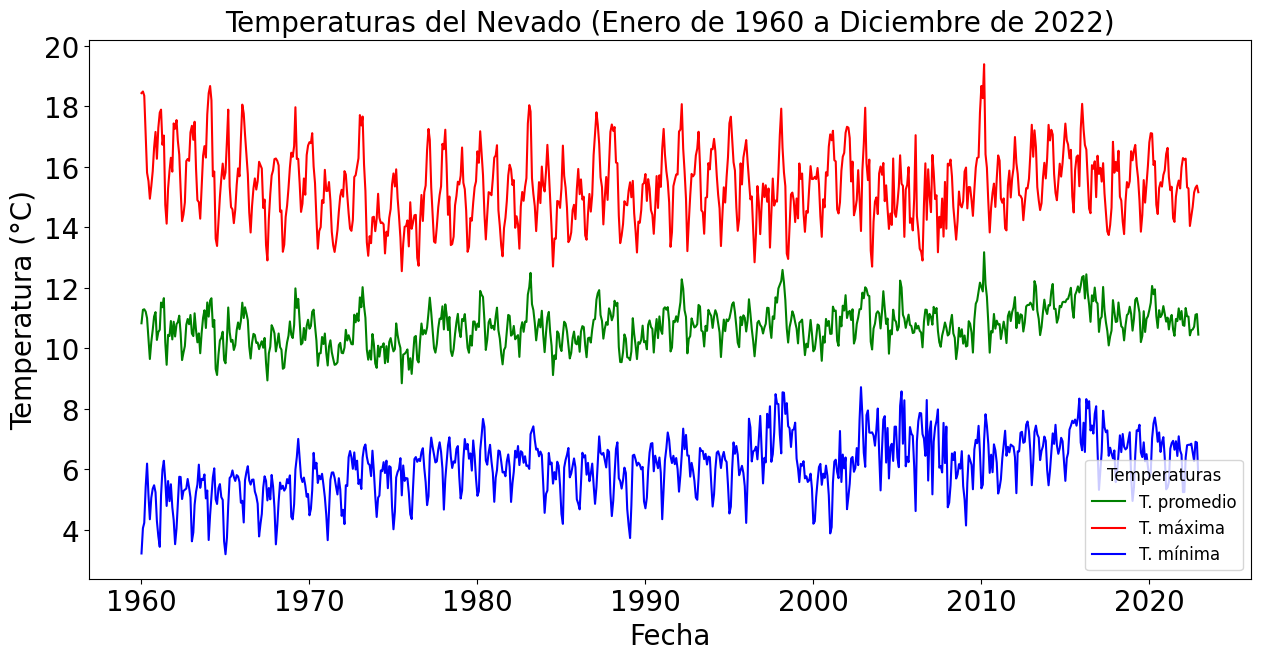

In [55]:
# Gráficos de líneas con dimensiones de 15 x 7

fig, ax = plt.subplots(figsize=(15,7))

sns.lineplot(data=df_Tprom, ax=ax, palette =["g"], legend=False,label="T. promedio")
sns.lineplot(data=df_Tmax, ax=ax, palette =["r"], legend=False,label="T. máxima")
sns.lineplot(data=df_Tmin, ax=ax, palette =["b"], legend=False,label="T. mínima")

ax.legend(title="Temperaturas",title_fontsize=12,fontsize=12, loc="lower right")
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_ylabel('Temperatura (°C)',fontsize=20)
ax.set_xlabel('Fecha',fontsize=20)
ax.set_title('Temperaturas del Nevado (Enero de 1960 a Diciembre de 2022)',fontsize=20)

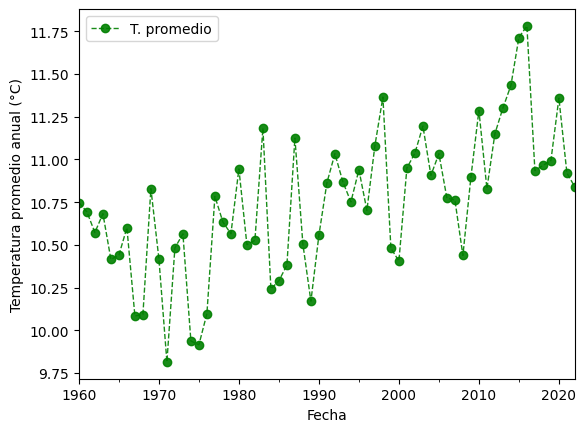

In [56]:
df_Tprom.groupby(pd.Grouper(freq='Y')).mean().plot(legend=False,
                                                   ylabel="Temperatura promedio anual (°C)",
                                                   color="g", alpha=0.9, style="--", lw=1,
                                                  marker="o")
plt.legend(["T. promedio"])
plt.show()

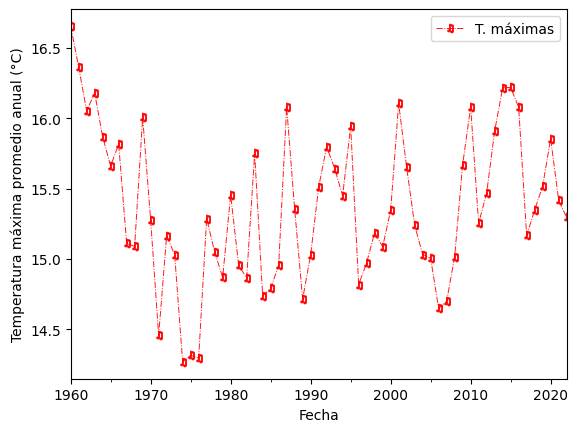

In [57]:
df_Tmax.groupby(pd.Grouper(freq='Y')).mean().plot(legend=False,
                                                   ylabel="Temperatura máxima promedio anual (°C)",
                                                   color="r", alpha=0.9, style="-.", lw=.7,
                                                 marker="$\u266B$")
plt.legend(["T. máximas"])
plt.show()

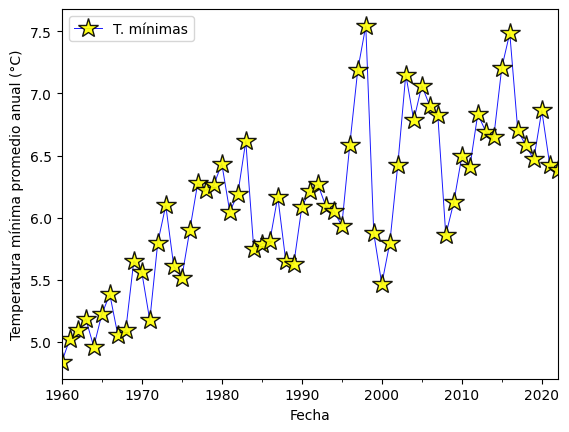

In [58]:
df_Tmin.groupby(pd.Grouper(freq='Y')).mean().plot(legend=False,
                                                   ylabel="Temperatura mínima promedio anual (°C)",
                                                   color="b", alpha=0.9, style="-", lw=.7,
                                                  marker="*",markersize=15,markerfacecolor='yellow',
                                                 markerfacecoloralt='green',markeredgecolor='black',
                                                 markeredgewidth=1)
plt.legend(["T. mínimas"])
plt.show()

<Axes: ylabel='Frequency'>

<Figure size 640x480 with 0 Axes>

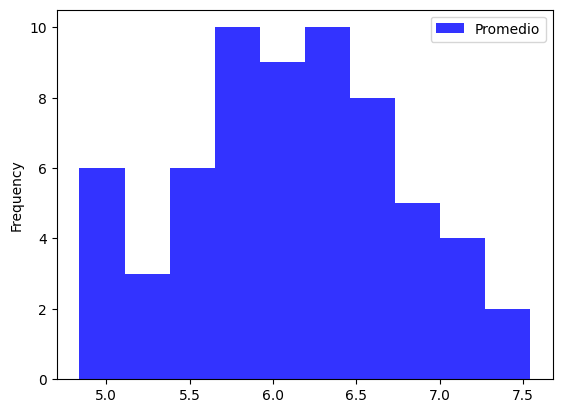

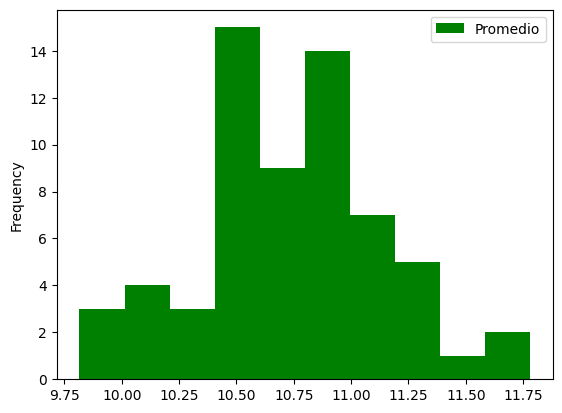

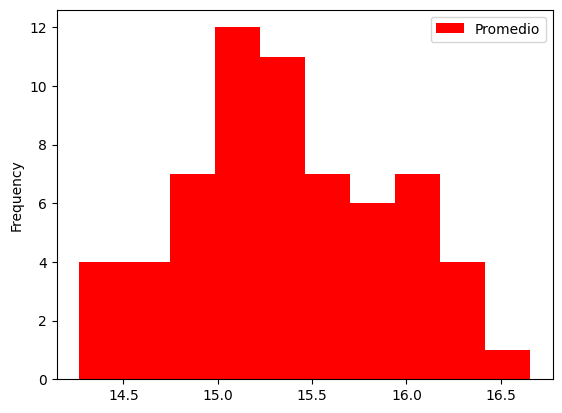

In [59]:
plt.figure();

df_Tmin.groupby(pd.Grouper(freq='Y')).mean().plot.hist(color="b", alpha=0.8)
df_Tprom.groupby(pd.Grouper(freq='Y')).mean().plot.hist(color="g")
df_Tmax.groupby(pd.Grouper(freq='Y')).mean().plot.hist(color="r")

In [60]:
#Vamos a crear la columna de años y meses para las temperaturas mínimas
df_Tmin["años"] = np.array(df_Tmin.index.year)
df_Tmin["meses"] = np.array(df_Tmin.index.month)

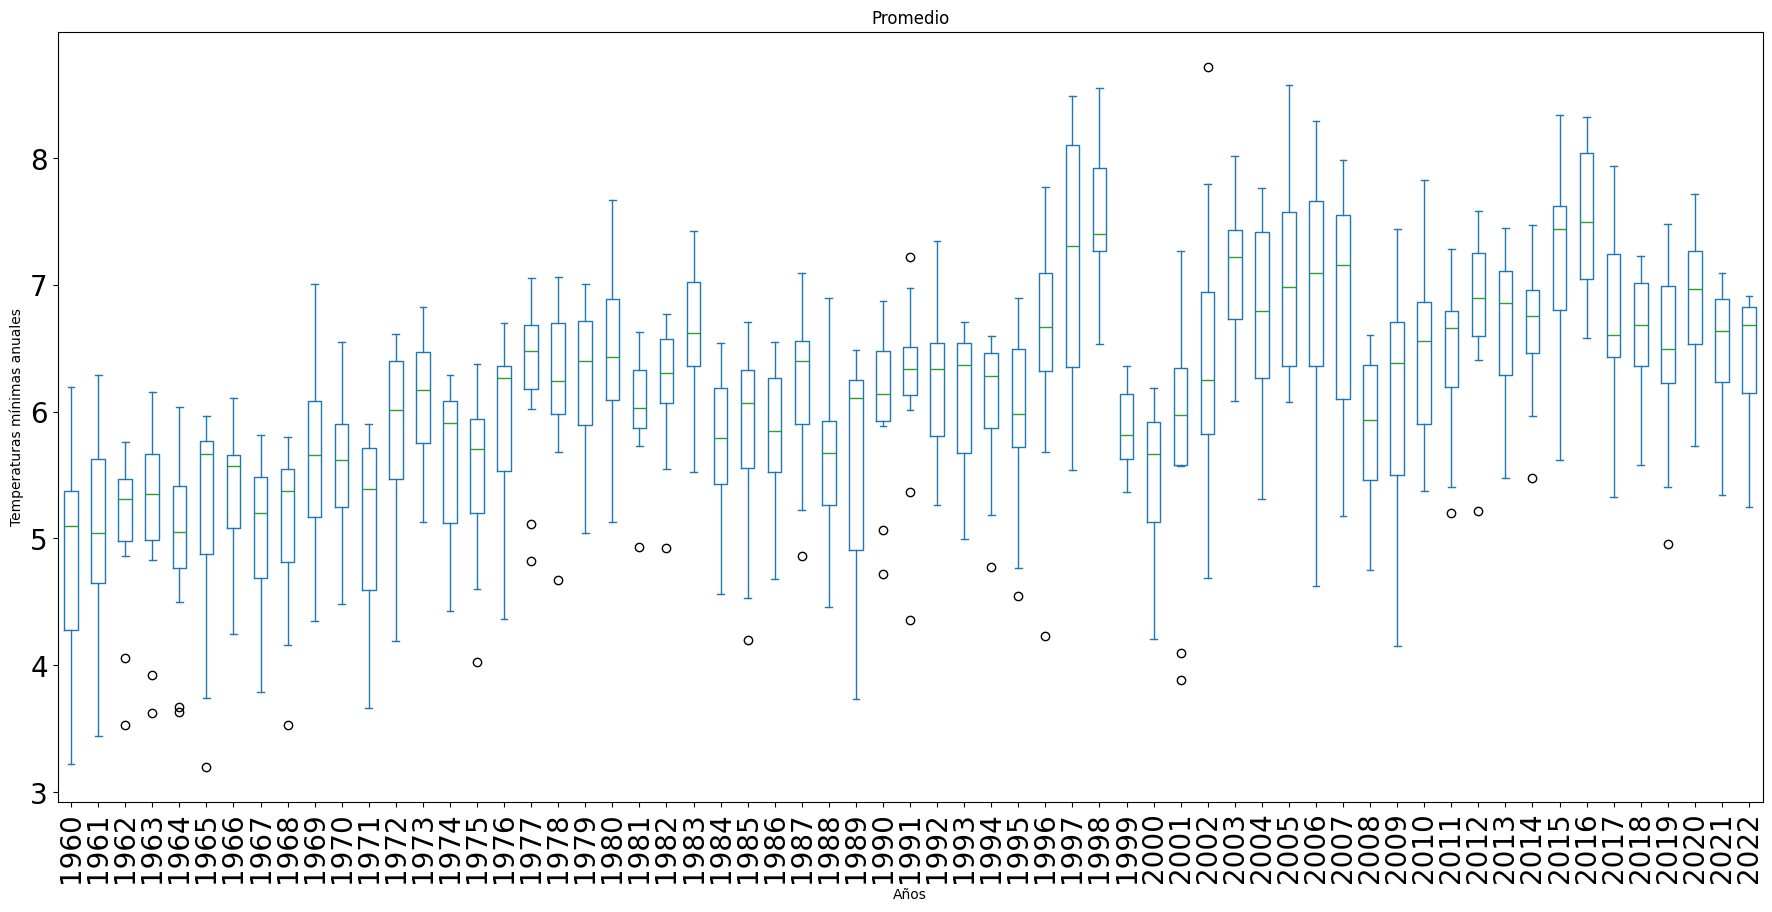

In [61]:
df_Tmin.plot.box(by="años", column=["Promedio"],figsize=(22,10), fontsize=20, 
                 ylabel="Temperaturas mínimas anuales", xlabel="Años", rot=90)
plt.show()

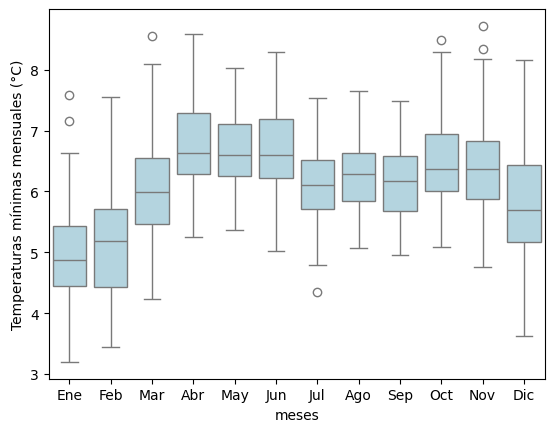

In [62]:
fig, ax = plt.subplots()
sns.boxplot(data=df_Tmin, x="meses", y="Promedio", palette=["lightblue"])
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"])
ax.set_ylabel("Temperaturas mínimas mensuales (°C)")
plt.show()